In [26]:
# library
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import json
from sklearn import manifold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from xgboost import plot_tree

### check submission style

In [27]:
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")
sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# Data info

In [28]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Null count

In [29]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## HomePlanet info

In [30]:
train["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

## Cabin info

In [31]:
# 1st info
print(train["Cabin"].str[:1].unique())
# 2nd info
print(train["Cabin"].str[2:3].unique())
# 3rd info
print(train["Cabin"].str[-1:].unique())

# 3rd value counts (I used only 3rd value)
train["Cabin"].str[-1:].value_counts()

['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
['0' '1' '2' '3' nan '4' '5' '6' '8' '9' '7']
['P' 'S' nan]


S    4288
P    4206
Name: Cabin, dtype: int64

In [32]:
train["Cabin"].str.split("/", expand=True)

,0,1,2
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


## Dest

In [33]:
# destination value counts
train["Destination"].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

## Age info

In [34]:
print("min : {}, max : {}, median : {}".format(train["Age"].min(), train["Age"].max(), train["Age"].median()))
print("age distribution")
age_dist = pd.cut(train["Age"], list(range(0, 100, 10))).value_counts()
age_dist

min : 0.0, max : 79.0, median : 27.0
age distribution


(20, 30]    2668
(10, 20]    1717
(30, 40]    1680
(40, 50]     994
(0, 10]      540
(50, 60]     517
(60, 70]     183
(70, 80]      37
(80, 90]       0
Name: Age, dtype: int64

## Name info

In [35]:
# split Name to first name and family name
name_df = train["Name"].str.split(" ", expand = True)
name_df = name_df.rename(columns = {0: "FirstName", 1: "FamilyName"})
name_df

,FirstName,FamilyName
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines
...,...,...
8688,Gravior,Noxnuther
8689,Kurta,Mondalley
8690,Fayey,Connon
8691,Celeon,Hontichre


In [36]:
name_df["FamilyName"].value_counts()

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
              ..
Covale         1
Dun            1
Witalnerod     1
Deryplinet     1
Sionerorly     1
Name: FamilyName, Length: 2217, dtype: int64

## Numerical analysis

In [37]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [38]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


# Data preprocessing

In [39]:
train_x = train.drop(columns = ["Transported"])
train_y = train["Transported"]

In [40]:
test_x = pd.read_csv("../input/spaceship-titanic/test.csv")
test_index = test_x["PassengerId"]

In [41]:
# remove unused information
# ["PassengerId", "Name"]
train_x = train_x.drop(columns=["PassengerId", "Name"])
test_x = test_x.drop(columns=["PassengerId", "Name"])

# replace Cabin with Cabin-3rd-information
train_x["Cabin"] = train_x["Cabin"].str[-1:]
test_x["Cabin"] = test_x["Cabin"].str[-1:]

In [42]:
# in "CryoSleep", True = 1, Nan = 0, False = -1
train_x["CryoSleep"] = train_x["CryoSleep"].replace({True : 1, False : -1})
train_x["CryoSleep"] = train_x["CryoSleep"].fillna(0)
test_x["CryoSleep"] = test_x["CryoSleep"].replace({True : 1, False : -1})
test_x["CryoSleep"] = test_x["CryoSleep"].fillna(0)

# in Cabin, create new Columns, [Cabin-P, Cabin-S]
# P and S may have meanings that cannot be expressed in terms of numerical values
# same for HomePlanet, Destination, VIP
train_x = pd.get_dummies(train_x, columns=["HomePlanet", "Cabin", "Destination"])
test_x = pd.get_dummies(test_x, columns=["HomePlanet", "Cabin", "Destination"])

# in VIP, convert from boolean to numeric
train_x["VIP"] *= 1
train_x["VIP"] = train_x["VIP"].fillna(0)
test_x["VIP"] *= 1
test_x["VIP"] = test_x["VIP"].fillna(0)

In [43]:
train_x.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_P,Cabin_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,-1.0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1
1,-1.0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,1,0,0,1
2,-1.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,1,0,0,1
3,-1.0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,1,0,0,1
4,-1.0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,1,0,0,1


In [44]:
from xgboost import XGBClassifier

In [45]:
model = XGBClassifier(n_estimators = 20, random_state=71)
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=71,
              reg_alpha=0, reg_lambda=1, ...)

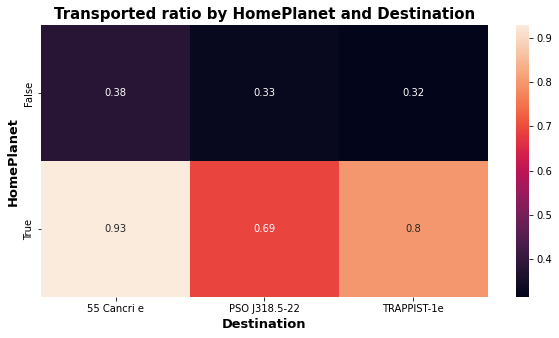

In [51]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='CryoSleep', columns='Destination', values='Transported'), annot=True)
g.set_title('Transported ratio by HomePlanet and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()


In [53]:
pd.crosstab([train.CryoSleep, train.Transported], train.HomePlanet,margins=True)


HomePlanet             Earth  Europa  Mars   All
CryoSleep Transported                           
False     False         2109     697   757  3563
          True           997     465   290  1752
True      False          475      10    59   544
          True           907     901   610  2418
All                     4488    2073  1716  8277

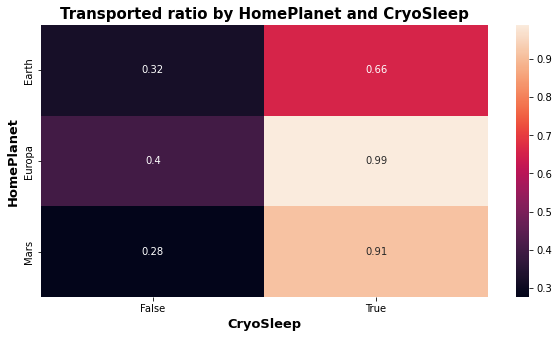

In [54]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='CryoSleep', values='Transported'), annot=True)
g.set_title('Transported ratio by HomePlanet and CryoSleep', weight='bold', size=15)
g.set_xlabel('CryoSleep', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()


In [46]:
pred = model.predict_proba(test_x)[:, 1]

In [47]:
pred_label = np.where(pred > 0.5, True, False)
pred_label

array([ True, False,  True, ...,  True,  True,  True])

In [48]:
submission = pd.DataFrame({"PassengerId": test_index, "Transported": pred_label})
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [55]:
tmp = train.copy()
tmp['AgeBin'] = 7
for i in range(6):
    tmp.loc[(tmp.Age >= 10*i) & (tmp.Age < 10*(i + 1)), 'AgeBin'] = i
cat_dist(tmp, var='AgeBin', hue='Transported', msg_show=False)


NameError: name 'cat_dist' is not defined

In [49]:
submission.to_csv("submission.csv", index=False)